In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
sys.path.append('../../graph-conv')
sys.path.append('../../../ecg/v4')

import numpy as np

import pandas as pd

import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.metrics import (f1_score, classification_report, 
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, roc_auc_score)
from sklearn.utils import compute_class_weight

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from pysmiles import read_smiles
from graph import SpectralGCN
from ecg.datasets import Dataloader
from ecg.train_utils import (check_sampling_status, 
                             update_weighted_sampling, 
                             SampleLossStorage)

In [2]:
df = pd.read_csv('../data/B3DB_classification.tsv', sep='\t')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7807 entries, 0 to 7806
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NO.            7807 non-null   int64  
 1   compound_name  6698 non-null   object 
 2   IUPAC_name     6170 non-null   object 
 3   SMILES         7807 non-null   object 
 4   CID            6170 non-null   float64
 5   logBB          1058 non-null   float64
 6   BBB+/BBB-      7807 non-null   object 
 7   Inchi          7807 non-null   object 
 8   threshold      3621 non-null   float64
 9   reference      7807 non-null   object 
 10  group          7807 non-null   object 
 11  comments       18 non-null     object 
dtypes: float64(3), int64(1), object(8)
memory usage: 732.0+ KB
None


,NO.,compound_name,IUPAC_name,SMILES,CID,logBB,BBB+/BBB-,Inchi,threshold,reference,group,comments
0,1,sulphasalazine,2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,5339.0,-2.69,BBB-,InChI=1S/C18H14N4O5S/c23-16-9-6-13(11-15(16)18...,NaN,R2|R2|R25|R46|,A,NaN
1,2,moxalactam,7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,3889.0,-2.52,BBB-,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,NaN,R25|,A,NaN
2,3,clioquinol,5-chloro-7-iodoquinolin-8-ol,Oc1c(I)cc(Cl)c2cccnc12,2788.0,-2.40,BBB-,InChI=1S/C9H5ClINO/c10-6-4-7(11)9(13)8-5(6)2-1...,NaN,R18|R26|R27|,A,NaN
3,4,bbcpd11 (cimetidine analog) (y-g13),2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...,CCNC(=NCCSCc1ncccc1Br)NC#N,14022517.0,-2.15,BBB-,InChI=1S/C12H16BrN5S/c1-2-15-12(18-9-14)17-6-7...,NaN,R2|R2|R8|R40|R2|R2|R2|R2|R18|R21|R25|R25|R26|R...,A,NaN
4,5,schembl614298,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...",CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,18595497.0,-2.15,BBB-,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...,NaN,R25|,A,NaN


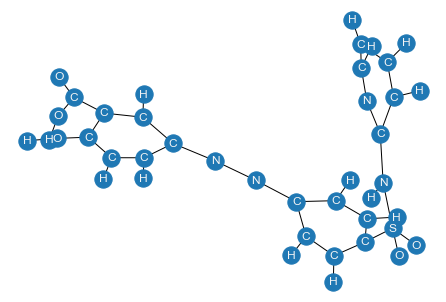

In [3]:
np.random.seed(345)
smiles = df.loc[0, 'SMILES']
mol = read_smiles(smiles, explicit_hydrogen=True)
nx.draw(mol, labels=dict(mol.nodes(data='element')), with_labels=True, font_color='whitesmoke')

In [4]:
def get_adj_mat(mol):
    try:
        A = nx.adjacency_matrix(mol).toarray()
    except AttributeError:
        A = np.nan
    return A

def get_elems(mol):
    try:
        elems = list(dict(mol.nodes(data='element')).values())
    except AttributeError:
        elems = np.nan
    return elems

def get_BBB(BBB):
    parse_dict = {'BBB-': 0, 'BBB+': 1}
    p = parse_dict[BBB]
    return p

mols = df['SMILES'].apply(read_smiles)
adj_mat = mols.apply(get_adj_mat).tolist()
elems = mols.apply(get_elems).tolist()
permeable = df['BBB+/BBB-'].apply(get_BBB).tolist()

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical info

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informatio

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information t

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information t

E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical info

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information th

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which i

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereoc

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information t

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information t

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical infor

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, wh

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that

E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical informatio

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical i

Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information,

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is sp

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information t

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereoc

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains ster

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereoch

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical info

Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemi

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereoche

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains st

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, w

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical infor

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical info

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereoc

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical inf

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stere

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereoc

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical i

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical inform

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contai

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical info

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereo

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical inf

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical info

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information th

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information th

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is sp

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informati

Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, whi

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical informatio

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information th

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical informatio

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information th

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical inf

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@H]" contains stereoch

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereo

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical infor

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" co

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information t

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information tha

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information th

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information tha

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical inform

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information th

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical infor

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information 

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information th

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informatio

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stere

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informatio

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical infor

Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains 

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical 

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information,

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical info

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information t

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which i

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inf

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical in

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informa

E/Z stereochemical information, which is specified by "\", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical in

Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical 

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informat

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informa

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information tha

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical in

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information tha

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical inform

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information 

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information th

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informatio

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical info

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical infor

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical inform

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which 

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informati

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information th

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information th

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information 

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical info

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical informa

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.


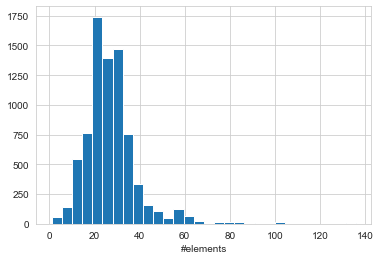

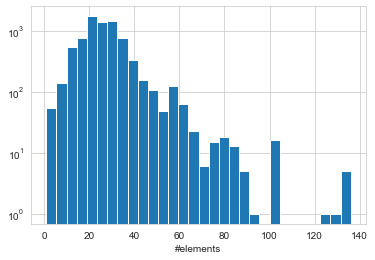

In [5]:
num_elems = np.array(list(map(lambda elems_i: len(elems_i), elems)))

plt.hist(num_elems, bins=30)
plt.xlabel('#elements')
plt.show()

plt.hist(num_elems, bins=30)
plt.xlabel('#elements')
plt.yscale('log')
plt.show()

In [6]:
N = num_elems.max()
N

136

In [7]:
max_len = 90

In [8]:
vocab = []
for elems_i in elems:
    vocab.extend(elems_i)
    
vocab = ['UNK'] + sorted(set(vocab))

vocab2int = {v: i for i, v in enumerate(vocab, start=1)}
int2vocab = {i: v for v, i in vocab2int.items()}

vocab

['UNK',
 'Ar',
 'B',
 'Br',
 'C',
 'Cl',
 'F',
 'I',
 'Kr',
 'Li',
 'N',
 'Ne',
 'O',
 'P',
 'S',
 'Si',
 'Xe']

In [9]:
X = np.stack([list(map(lambda e: vocab2int[e], elems_i)) + (N-len(elems_i))*[0] for elems_i in elems])
X = torch.from_numpy(X[:, :max_len]).long()
X.size()

torch.Size([7807, 90])

In [10]:
def pad(arr, n):
    padded = np.zeros((n, n))
    padded[:len(arr), :len(arr)] = arr
    return padded

A = np.stack([pad(adj_mat_i, N) for adj_mat_i in adj_mat])
A = torch.from_numpy(A[:, :max_len, :max_len]).float()
A.size()

torch.Size([7807, 90, 90])

In [11]:
Y = torch.LongTensor(permeable)
Y.size()

torch.Size([7807])

In [12]:
class TensorDataset(Dataset):

    def __init__(self,
                 A,
                 X,
                 Y,
                 weighted_sampling=False,
                 transform=None):
        super(TensorDataset, self).__init__()

        self.A = A
        self.X = X
        self.Y = Y
        self.weighted_sampling = weighted_sampling
        self.transform = transform
        
        self.initial_weight_ = 1000.0
        self._init_weighted_sampling()

    def __getitem__(self, idx):
        a = self.A[idx]
        x = self.X[idx]
        y = self.Y[idx]

        if self.transform is not None:
            x = self.transform(x)

        return a, x, y, idx

    def _init_weighted_sampling(self):
        if self.weighted_sampling:
            self.weight_dict = {}
            self.sampling_counter = {'count': 0}
            for idx in range(self.__len__()):
                self.weight_dict[idx] = self.initial_weight_
                self.sampling_counter[idx] = 0

    def __len__(self):
        return len(self.Y)

In [13]:
weighted_sampling = True
batch_size = 128

dataset = TensorDataset(A, X, Y, weighted_sampling=weighted_sampling)
dataloader = Dataloader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)
dataloader_full = Dataloader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [14]:
embedding_dim = 8
embedding = nn.Embedding(len(vocab)+1, embedding_dim, padding_idx=0)

In [15]:
model_params = {
    'in_features': embedding_dim,
    'n_hidden_neurons': [128, 128, 64],
    'hidden_dim': None,
    'out_features': None,
    'bias': True,
    'activation': 'gelu',
    'pooling': False,
    'flatten': False,
    'seed': 42
}    

gcnn = SpectralGCN(**model_params)
gcnn

SpectralGCN(
  (graph): ModuleList(
    (0): GraphConv(in_features=8, out_features=128, bias=True)
    (1): GraphConv(in_features=128, out_features=128, bias=True)
    (2): GraphConv(in_features=128, out_features=64, bias=True)
  )
)

In [16]:
d_model = model_params['n_hidden_neurons'][-1]
size = (1, max_len, d_model)
cls_token = nn.Parameter(torch.randn(*size))
cls_token.size()

torch.Size([1, 90, 64])

In [17]:
nhead = 8
dim_feedforward = 4 * d_model
dropout = 0.1
activation = 'gelu'
num_layers = 2

encoder_layer = nn.TransformerEncoderLayer(d_model, 
                                           nhead,
                                           dim_feedforward=dim_feedforward,
                                           dropout=dropout, 
                                           activation=activation, 
                                           batch_first=True)
transformer_enc = nn.TransformerEncoder(encoder_layer, num_layers)
transformer_enc

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=256, out_features=64, bias=

In [18]:
classifier = nn.Linear(d_model, 2)
classifier

Linear(in_features=64, out_features=2, bias=True)

In [19]:
def feed_forward(a, x, return_features=False):
    x_embed = embedding(x)
    gcnn_out = gcnn(a, x_embed)
    enc_in = torch.cat([cls_token.expand_as(gcnn_out), gcnn_out], dim=1)
    enc_out = transformer_enc(enc_in)
    cls_in = enc_out[:, 0]
    out = classifier(cls_in)
    if return_features:
        return out, cls_in
    return out

In [20]:
a, x, y, idx = iter(dataloader).next()

out = feed_forward(a, x)
out.size()

torch.Size([128, 2])

In [21]:
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(permeable), 
                                     y=permeable)
class_weights = torch.from_numpy(class_weights).float()
class_weights

tensor([1.3692, 0.7876])

In [22]:
lr = 5e-4
weight_decay = 1e-5

params = list(embedding.parameters()) \
    + list(gcnn.parameters()) \
    + [cls_token] \
    + list(transformer_enc.parameters()) \
    + list(classifier.parameters())
optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)
optimizer.zero_grad()

criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='none')

In [ ]:
num_epochs = 30

data_iter = iter(dataloader)

storage = SampleLossStorage()
losses = []

update_every = 1
sampling_kwargs = {
    'min_clip': 5,
    'max_clip': 95,
    'min_max_scaling': True,
    'eps': 1.0, 
    'topk_errors': 20
}

i_iter = 0

embedding.train()
gcnn.train()
transformer_enc.train()
classifier.train()

for epoch in range(1, num_epochs+1):
    sample_losses = []
    ys = []
    preds = []
    for _ in tqdm(range(len(dataloader)), desc=f'Epoch {epoch}', leave=False):
        _, sampled = check_sampling_status(dataloader)
        if sampled:
            criterion = nn.CrossEntropyLoss(weight=None, reduction='none')
            
        a, x, y, idx = data_iter.next()
        i_iter += 1
        
        out = feed_forward(a, x)
        sample_loss = criterion(out, y)
        loss = sample_loss.sum()
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(params, max_norm=1.0, norm_type=2.0)
        optimizer.step()        
        
        sample_losses.extend(sample_loss.squeeze().detach().numpy().tolist())
        ys.extend(y.squeeze().numpy().tolist())
        preds.extend(out.argmax(dim=1).detach().numpy().tolist())
        
        if dataloader.dataset.weighted_sampling:
            storage.add(idx, sample_loss.squeeze())
        
            if i_iter % update_every == 0:
                sampling_kwargs['print_stats'] = False
                dataloader = update_weighted_sampling(dataloader, storage, **sampling_kwargs)

                data_iter = iter(dataloader)
                storage.reset()
    
    loss = np.mean(sample_losses)
    losses.append(loss)
    
    score = f1_score(ys, preds)
    
    print(f'Epoch {epoch} - BCE loss: {loss:.6f} | F1 score: {score:.6f}')
    if sampled:
        print()
        sampling_kwargs['print_stats'] = True
        _ = update_weighted_sampling(dataloader, storage, **sampling_kwargs)

Epoch 1 - BCE loss: 0.613359 | F1 score: 0.721311


Epoch 2 - BCE loss: 0.587019 | F1 score: 0.770351

TOP 20 ERRORS:
- 189: 4.5201 | 2
- 187: 4.4442 | 2
- 207: 4.2754 | 2
- 2528: 3.8919 | 2
- 6779: 3.6412 | 3
- 3089: 3.5306 | 1
- 5677: 3.3430 | 1
- 657: 3.2520 | 2
- 829: 3.2508 | 1
- 3505: 3.2270 | 1
- 5567: 3.1894 | 1
- 6560: 3.1148 | 1
- 5657: 3.0235 | 1
- 7458: 2.9944 | 1
- 2923: 2.9672 | 1
- 3710: 2.9350 | 3
- 5836: 2.9085 | 1
- 2246: 2.8902 | 1
- 5153: 2.8684 | 1
- 5524: 2.8657 | 1



Epoch 3 - BCE loss: 0.563930 | F1 score: 0.796316

TOP 20 ERRORS:
- 207: 4.2754 | 2
- 7709: 3.5738 | 3
- 188: 3.3048 | 3
- 657: 3.2520 | 2
- 3505: 3.2270 | 1
- 186: 3.0718 | 2
- 5657: 3.0235 | 1
- 187: 3.0233 | 3
- 5052: 2.9994 | 5
- 6779: 2.9864 | 6
- 5002: 2.9556 | 2
- 829: 2.8233 | 3
- 4665: 2.7450 | 6
- 189: 2.7368 | 4
- 2528: 2.6787 | 3
- 462: 2.6778 | 3
- 5151: 2.6773 | 4
- 5589: 2.6741 | 3
- 1952: 2.6569 | 6
- 3710: 2.6324 | 8



Epoch 4 - BCE loss: 0.575330 | F1 score: 0.787086

TOP 20 ERRORS:
- 186: 3.4599 | 3
- 3505: 3.2270 | 1
- 829: 2.9935 | 4
- 187: 2.8755 | 4
- 6779: 2.8451 | 8
- 1073: 2.8347 | 3
- 5002: 2.7858 | 4
- 7369: 2.7694 | 2
- 591: 2.5997 | 3
- 2528: 2.5700 | 7
- 3710: 2.5631 | 11
- 1957: 2.5491 | 6
- 6814: 2.5312 | 4
- 5052: 2.4831 | 8
- 348: 2.4582 | 9
- 5590: 2.4433 | 5
- 5591: 2.3571 | 3
- 1644: 2.3447 | 4
- 207: 2.3204 | 4
- 5817: 2.3173 | 3



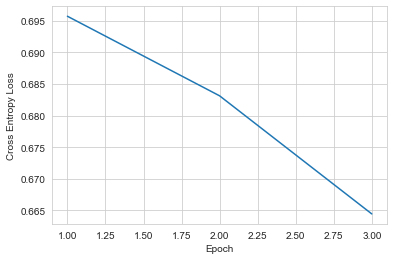

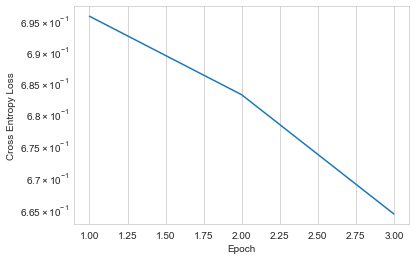

In [134]:
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log')
plt.show()

In [75]:
embedding.eval()
gcnn.eval()
transformer_encoder.eval()
classifier.eval()
with torch.no_grad():
    features = []
    y_true = []
    y_pred = []
    for a, x, y in tqdm(dataloader_full):
        out, feats = feed_forward(a, x, return_features=True)
        features.extend(feats.numpy().tolist())
        y_true.extend(y.squeeze().numpy().tolist())
        y_pred.extend(F.softmax(out, dim=1)[:, 1].numpy().tolist())

features = np.array(features)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
target_names = ['BBB-', 'BBB+']

In [76]:
np.savez('b3db-features.npz', data=features, target=y_true, target_names=target_names)
np.savez('../../self-organizing-map/data/b3db-features.npz', 
         data=features, target=y_true, target_names=target_names)

weights = {
    'embedding': embedding.state_dict(),
    'gcnn': gcnn.state_dict(),
    'cls_token': cls_token,
    'transformer_enc': transformer_enc.state_dict(),
    'classifier': classifier.state_dict()
}
torch.save(weights, 'b3db-weights.pt')

In [77]:
print(classification_report(y_true, y_pred > 0.5, target_names=target_names))

              precision    recall  f1-score   support

        BBB-       0.74      0.81      0.77      2851
        BBB+       0.88      0.83      0.86      4956

    accuracy                           0.82      7807
   macro avg       0.81      0.82      0.81      7807
weighted avg       0.83      0.82      0.83      7807



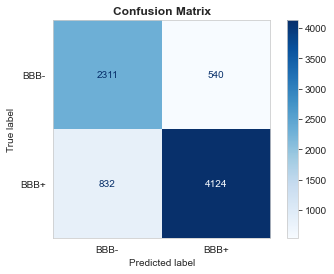

In [78]:
cm = confusion_matrix(y_true, y_pred > 0.5)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
_ = disp.plot(cmap='Blues')
plt.title('Confusion Matrix', fontweight='bold')
plt.grid(False)

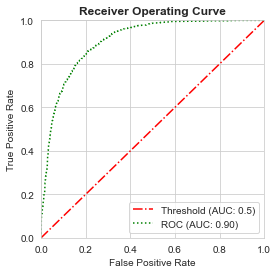

In [87]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
auc = roc_auc_score(y_true, y_pred)

plt.figure(figsize=(4, 4))
plt.plot([0.0, 1.0], [0.0, 1.0], c='red', ls='-.', label='Threshold (AUC: 0.5)')
plt.plot(fpr, tpr, c='green', ls=':', label=f'ROC (AUC: {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve', fontweight='bold')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()